 Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import random

# Load dataset
df = pd.read_csv("marketing_campaign.csv", sep=';')

# Quick check
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


Preprocess Data

In [2]:
# Drop rows with missing income
df = df.dropna(subset=["Income"])

# Total spend as proxy for campaign-related spend
df["TotalSpend"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Segment customers (simplified): High, Mid, Low income
df["Segment"] = pd.qcut(df["Income"], q=3, labels=["Low", "Mid", "High"])

/tmp/ipython-input-2-1576163371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalSpend"] = (
/tmp/ipython-input-2-1576163371.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Segment"] = pd.qcut(df["Income"], q=3, labels=["Low", "Mid", "High"])


Simulate A/B Test Grouping

In [3]:
# Random assignment
random.seed(42)
df["Group"] = np.where(np.random.rand(len(df)) > 0.5, "Treatment", "Control")

# Simulate campaign cost
df["Campaign_Cost"] = 20  # Flat cost per user

Calculate Response & Spend Uplift

In [4]:
# Group-level response rate
response_rates = df.groupby("Group")["Response"].mean()

# Group-level spend uplift
avg_spend = df.groupby("Group")["TotalSpend"].mean()

# T-test on spend
t_stat, p_val = ttest_ind(
    df[df["Group"] == "Treatment"]["TotalSpend"],
    df[df["Group"] == "Control"]["TotalSpend"]
)

ROI Analysis Per Segment

In [5]:
roi_summary = df.groupby(["Segment", "Group"]).agg({
    "TotalSpend": "mean",
    "Response": "mean",
    "Campaign_Cost": "mean"
}).reset_index()

pivot = roi_summary.pivot(index="Segment", columns="Group")

pivot.columns = ["_".join(col).strip() for col in pivot.columns.values]

pivot["Spend_Uplift"] = pivot["TotalSpend_Treatment"] - pivot["TotalSpend_Control"]
pivot["Response_Uplift"] = pivot["Response_Treatment"] - pivot["Response_Control"]
pivot["ROI"] = ((pivot["Response_Uplift"] * pivot["TotalSpend_Treatment"]) - pivot["Campaign_Cost_Treatment"]) / pivot["Campaign_Cost_Treatment"]

/tmp/ipython-input-5-1590415575.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  roi_summary = df.groupby(["Segment", "Group"]).agg({


Save ROI Summary to Excel

In [7]:
pivot.to_excel("roi_summary.xlsx")

Visualize Results

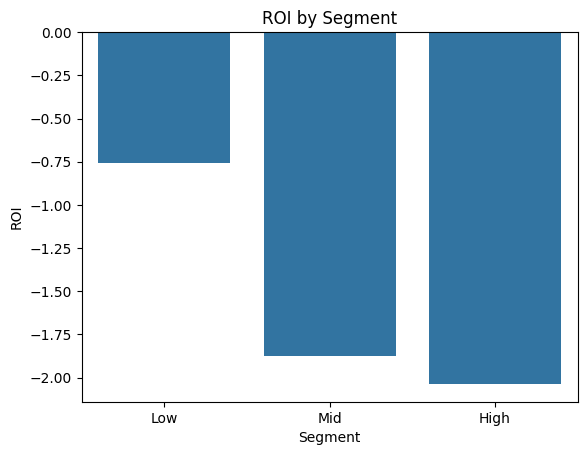

In [9]:
sns.barplot(x=pivot.index, y=pivot["ROI"])
plt.title("ROI by Segment")
plt.ylabel("ROI")
plt.xlabel("Segment")
plt.savefig("uplift_by_segment.png")
plt.show()